# TP INTELLIGENCE ARTIFICIELLE: Voyageur de Commerce

In [448]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random 
import time
from scipy.spatial import Delaunay
import math



# Données de test
N = 200 # Nombre de villes
#it = 7  nombre d'itération 
nb_individu = 20 # des fourmis pour l'algorithme à base de fourmis et des chromosome pour l'algorithme génétique


mean = [1,1] #[1,1]
cov = [[100,0], [0, 100]]#
data = np.random.multivariate_normal(mean, cov, N)# Coordonnées des différentes villes dans une carte 


## 1-Distance entre toute les paires de ville dans une Matrice M

In [449]:
# Distance entre toute les paires de villes

def Mat_dist(data):
    dist1=[]
    for element1 in data:
        dist2 = []
        for element2 in data:
            dist2.append(math.dist(element1,element2))
        dist1.append(dist2)
    return np.array(dist1)
     

In [450]:
M = Mat_dist(data) # Matrice des distances entre chaque ville
villes = list(range(0,len(M))) # Liste des ville


In [451]:

def afficher_tab(tab):
    for ligne in tab:
        for element in ligne:
            print(element, end=' ')
        print()
data.shape

(200, 2)

## 2- Visualisation des données 

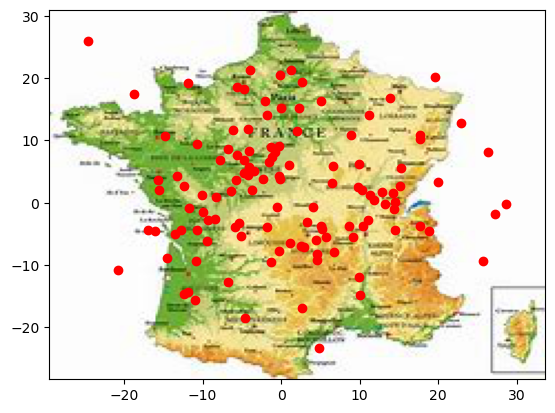

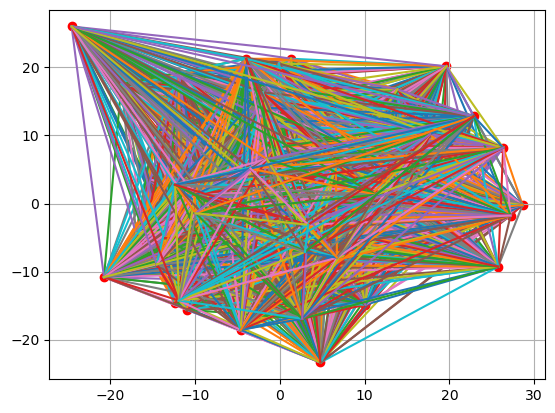

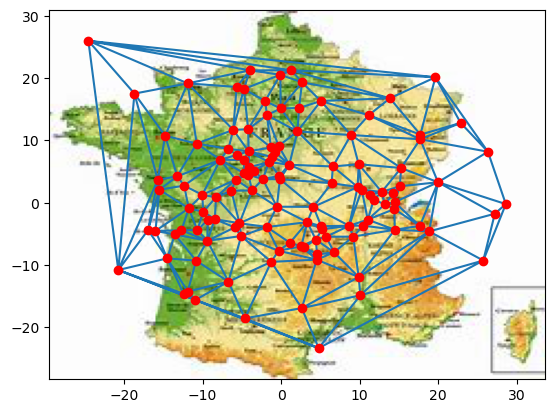

In [409]:

simplices = Delaunay(data).simplices

# tracer les points
plt.scatter(data[:, 0], data[:, 1], color='r')
img = mpimg.imread("france.jpg")
plt.imshow(img, extent=[min(data[:,0])-5, max(data[:,0])+5, min(data[:,1])-5, max(data[:,1])+5], aspect='auto', alpha=1)

plt.figure()
for i in range(len(data[:, 0])):
    for j in range(i+1, len(data[:, 0])):
        plt.plot([data[:, 0][i], data[:, 0][j]], [data[:, 1][i], data[:, 1][j]]) # relier chaque point à tous les autres points
        
plt.scatter(data[:, 0], data[:, 1], color='r')
plt.grid()
# afficher le graphe complet
plt.show()
plt.imshow(img, extent=[min(data[:,0])-5, max(data[:,0])+5, min(data[:,1])-5, max(data[:,1])+5], aspect='auto', alpha=1)

plt.triplot(data[:, 0], data[:, 1],simplices)
plt.scatter(data[:, 0], data[:, 1], color='r')

## 3- Création du population initiale

In [410]:
# Génère un population de taille nb_individu
def population(villes):
    pop = []
    for i in range(nb_individu):
        villes1 =  villes.copy()
        trajet = []
        j = len(villes1)
        while(j>0):
            k = np.random.choice(villes1)
            trajet.append(k)
            indx = villes1.index(k)
            del(villes1[indx])
            j = j-1
        pop.append(trajet)
    return pop
P = population(villes)

## 4- Distance des trajet pour parcourir toute les villes

In [411]:
def dist_trajet(popu,distance):
    dist = []
    for i in range(len(popu)):
        somme = 0.0
        villes1 = popu[i]
        for j in range(len(popu[0])):
            if(j+1<len(popu[0])):
                try:
                    somme = float(somme + distance[villes1[j],villes1[j+1]])
                except:
                    break
            else:
                break
        if(somme!=0):
            dist.append(somme +distance[villes1[0],villes1[len(villes1)-1]])
    
    return dist
#print(dist_trajet(P,M))

## I- Algorithme à base de fourmis

#### a- Phéromones sur chaque piste

In [412]:
# Villes:  represente la liste des numéro des villes
# M: representre la matrice des distances inter-ville
# Population: represente la liste des chemin emprunté par nb_individu fourmis
Q = 10 # quantité maximale de pheromene
pheromone_Initiale = 0.5
rho = 0.2 # Coefficient d'évaporisation
gamma = 0.0

def pheromone(popu, distances,init_phero = pheromone_Initiale*np.ones((N,N)) ):
    d = dist_trajet(popu,distances)
    phero = np.zeros((N,N))
     
    for i in range(nb_individu):
        for j in range(len(popu[i])):
            k = popu[i][j] # chemin de la fourmi i
            if(j+1<len(popu[i])):
                w = popu[i][j+1]
                phero[k,w] = phero[k,w]+ Q/d[i] 
                phero[w,k] = phero[k,w]
            else:    
                ville_int = popu[i][0] # ville initiale
                ville_fin = popu[i][len(popu[i])-1] # ville finale
                phero[ville_fin,ville_int] =phero[ville_fin,ville_int]+ Q/d[i] 
                phero[ville_fin,ville_int] = phero[ville_int,ville_fin]
            
    delta_tho = np.array(phero)
    next_tho = (1-rho)*init_phero + delta_tho
    
    return next_tho


#### b- Probailités de choix des villes non visitées

In [413]:
# Visibilité

def vis(i,j):
    if(M[i,j]==0):
        return 0
    return (1/M[i,j])

In [414]:
# Retourne la liste des probabilité d'aller de la num°i aux villes j non visité non

def P_ij(i,tau,non_visite,alpha,beta):
    Pi_j = []
    non_visite1 = non_visite.copy()
    somme = 0
    for l in non_visite1:
        somme = somme +gamma +(tau[i,l]**alpha)*(vis(i,l)**beta)
    for j in range(len(non_visite)):
        k = non_visite1[j]
        pij = (gamma + tau[i,k]**alpha)*(vis(i,k)**beta)/somme
        Pi_j.append(pij)
    return(Pi_j)

#### c- Choix par roulette (pour introduire un peu de hasard)
**Sélection de la roulette** : C'est une méthode largement utilisée et la plus efficace pour sélectionner les parents; c'est pourquoi nous l'utiliserons aujourd'hui dans notre algorithme. Nous savons tous comment fonctionne la roue de la roulette dans les casinos, laissez tomber la balle, faites tourner la roue et attendez que la roue s'arrête pour voir dans quel pot la balle tombe. Allons plus loin dans la partie mise en œuvre.

In [415]:
def roulette_russe(liste):
    n=np.random.random()
    liste1 = liste.copy()
    i=0
    t = 0
    vil =[];list2 =[]
    while(t<len(liste1)):
        i = i + liste1[t]
        list2.append(i);vil.append(t)
        t=t+1
    j=0
    s = list2[j]
    while (n>s) & (j<len(list2)-1):
        if(n>s):
            j=j+1;s = list2[j]
    return(vil[j])

In [430]:
def affichage(dist,popu1,tho,itera):
    
        d = list(dist_trajet(popu1,dist)); k = d.index(np.min(d))
        chemin1 = popu1[k]
        print("Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération",itera," à une longeur de:",d[k])
        opt=[]
        phero = [max(min(Q/2,2*tho[chemin1[i],chemin1[i+1]]),0.5) for i in range(len(chemin1)-1)] # pheromones sur la piste
        
        for i in range(len(chemin1)):
            opt.append(list(data[chemin1[i]])) # Récupération des coordonnées de chaque ville

        opt = np.array(opt)
        optx = opt[:,0] # X
        opty = opt[:,1] # Y
        # Tracer une ligne reliant les points
        plt.imshow(img, extent=[min(optx)-5, max(opty)+5, min(opty)-5, max(opty)+5], aspect='auto', alpha=1)
        plt.scatter(optx, opty,s=30, color='r')

        for i in range(len(optx)-1):
            plt.plot([optx[i], optx[i+1]], [opty[i], opty[i+1]],
                    linewidth=phero[i],color='blue')

        plt.title("Un chemin  après l'algorithme à base de fourmi")
        plt.show()   

#### d- Mise en place de l'algorithme à base de fourmis

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 0  à une longeur de: 2000.1008124024597


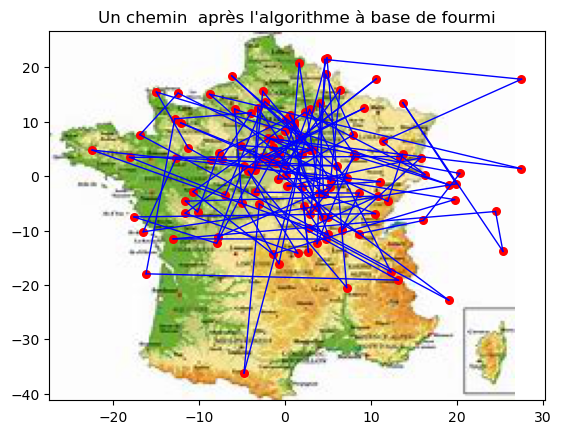

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 1  à une longeur de: 598.6472677171464


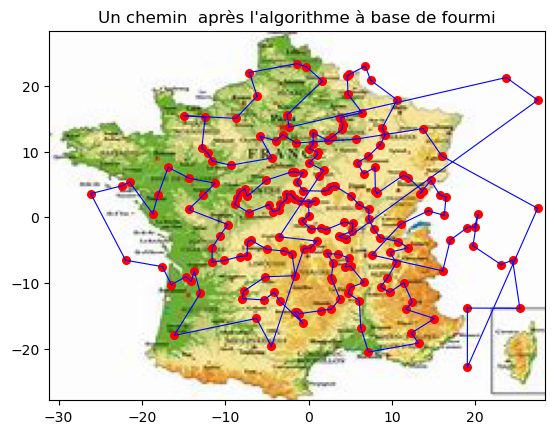

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 2  à une longeur de: 588.4128009230575


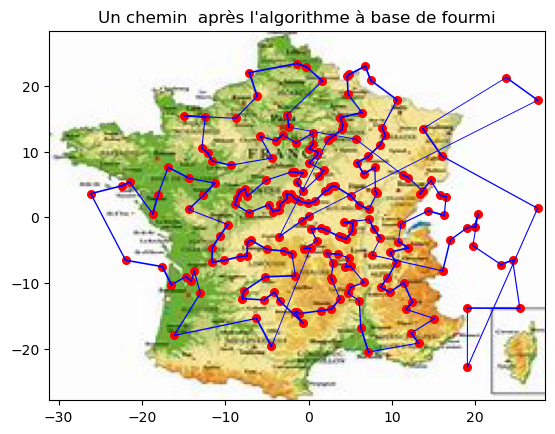

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 3  à une longeur de: 588.4128009230575


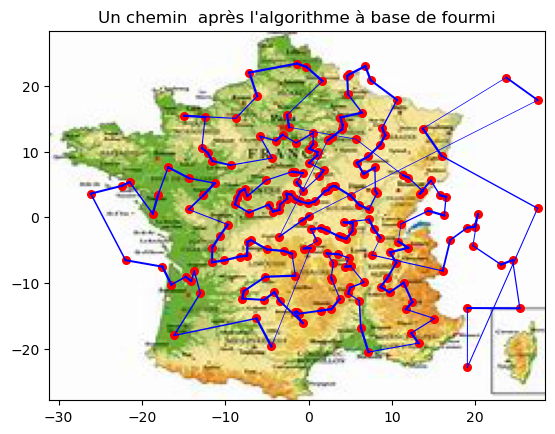

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 4  à une longeur de: 588.4128009230575


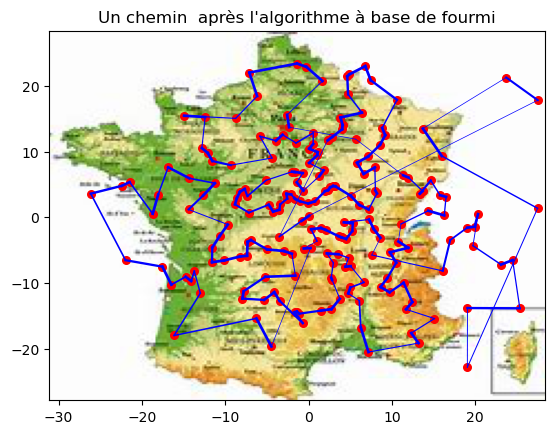

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 5  à une longeur de: 588.4128009230575


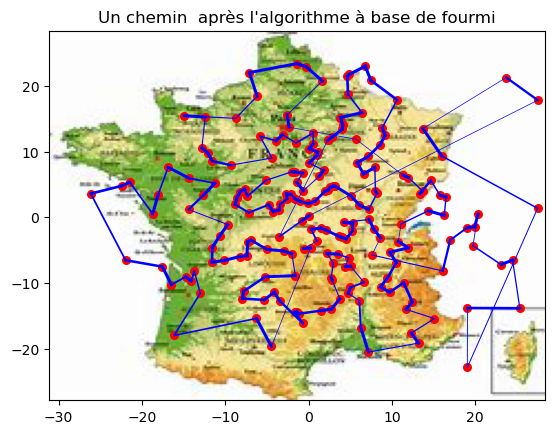

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 6  à une longeur de: 588.4128009230575


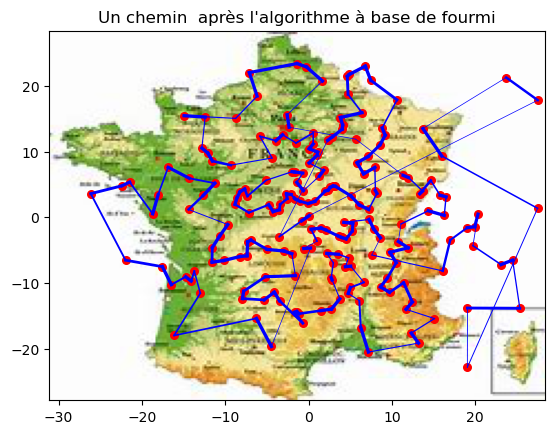

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 7  à une longeur de: 588.4128009230575


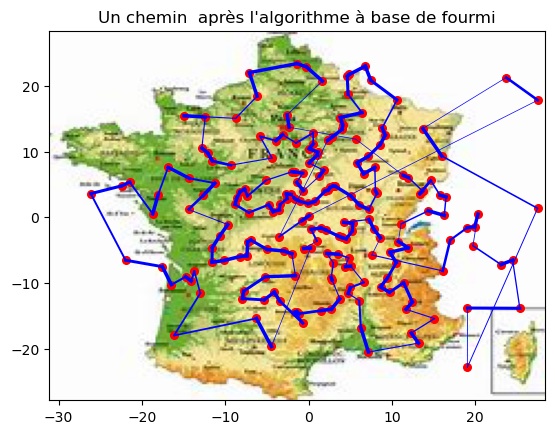

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 8  à une longeur de: 588.4128009230575


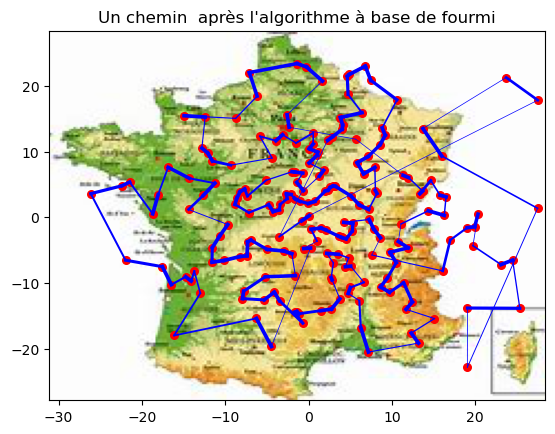

Un chemin optimale trouvé par l'algorithme à base de fourmis à l'itération 9  à une longeur de: 588.4128009230575


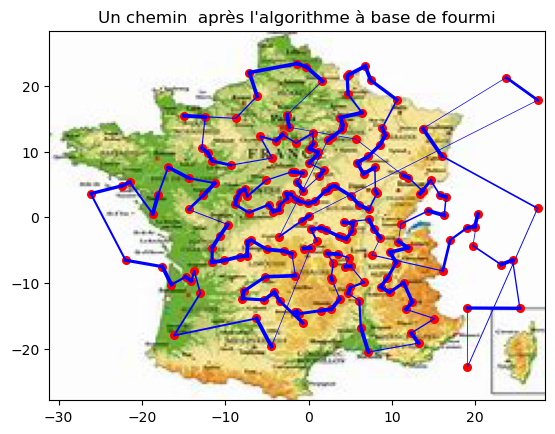

*******************************************************************************
Un chemin optimale trouvé par l'algorithme à base de fourmis est: [91, 54, 115, 157, 146, 81, 85, 97, 19, 169, 162, 34, 121, 108, 173, 198, 123, 131, 106, 55, 66, 124, 90, 195, 7, 22, 132, 120, 23, 192, 83, 28, 41, 148, 26, 47, 197, 105, 6, 111, 112, 153, 122, 69, 193, 59, 101, 84, 8, 65, 30, 3, 29, 181, 15, 57, 118, 95, 89, 61, 159, 150, 45, 86, 100, 194, 126, 187, 60, 36, 70, 31, 10, 39, 185, 186, 191, 16, 80, 82, 189, 113, 156, 114, 51, 190, 78, 127, 67, 144, 62, 109, 44, 149, 21, 176, 117, 177, 199, 182, 138, 155, 42, 64, 103, 139, 172, 102, 12, 20, 46, 2, 154, 88, 71, 0, 163, 48, 38, 93, 110, 184, 27, 166, 53, 168, 170, 145, 107, 94, 165, 152, 135, 13, 79, 99, 179, 151, 147, 11, 87, 52, 104, 183, 128, 9, 75, 161, 98, 77, 125, 141, 1, 137, 143, 40, 92, 175, 180, 134, 14, 35, 160, 196, 136, 188, 174, 33, 171, 50, 178, 49, 74, 68, 25, 142, 18, 140, 56, 158, 17, 167, 5, 37, 43, 58, 129, 32, 4, 164, 73, 24,

In [453]:

def algo_formi(popu,dist,villes,it,alpha=1,beta=100):
    popu1 = popu.copy()
    itera = 0
    tho = pheromone_Initiale*np.ones((N,N))
    pop = []
    affichage(dist,popu1,tho,itera)
    start_time = time.time()
    while(itera<it):
        tho = pheromone(popu1, dist,tho)
        for i in range(nb_individu):
            villes1 = villes.copy()
            chemin = []
            ville_i = np.random.choice(villes1); chemin.append(ville_i); villes1.remove(ville_i) # On choisi une ville, on l'ajoute dans notre chemin, Et on la supprime pour ne pas la parcourir deux fois                                                                                    
            while(len(villes1)>1):                            
                pi = list(P_ij(ville_i,tho,villes1,alpha,beta)) # liste des probas des villes non visitées
                next_ville = villes1[roulette_russe(pi)] # on choisi la nouvelle ville par la methode de roulette
                chemin.append(next_ville); ville_i = next_ville; villes1.remove(ville_i) # On ajoute cette nouvelle ville dans notre chemin et on la supprime de l'ensemble des ville restante  et on reprend le processus                                                         
            chemin.append(chemin[0])                                                                           
            pop.append(chemin) # On ajoute ce chemin dans la liste de la population: une fourmi vient de parcourir toute les ville
        itera = itera +1 
        popu1 = pop.copy() # les listes de chemins initiaux sont reinitialisées
        affichage(dist,popu1,tho,itera)
    end_time = time.time()
    d = list(dist_trajet(popu1,dist)); k = d.index(np.min(d)) # recherche de la distance minimale et ça position
    print("*******************************************************************************")
    print("Un chemin optimale trouvé par l'algorithme à base de fourmis est:",popu1[k])
    print("Un trajet optimale est long de",d[k],"Km")
    print("Nombre d'itération:  ",it,)
    print("Temps d'excétution: ",end_time - start_time,"secondes")
    print("*******************************************************************************")
   
    return popu1[k], d[k]
#che = algo_formi(P,M)
chemin,distance = algo_formi(P,M,villes,9,1,100)


def algo_formi2(popu,dist,alpha=1,beta=100):
    popu1 = popu.copy()
    itera = 0
    pop = []
    tho = pheromone_Initiale*np.ones((N,N))
    while(itera<it):
        tho = pheromone(popu1, dist,tho)
        for i in range(nb_individu):
            villes1 = villes.copy()
            chemin =[]
            ville_i =np.random.choice(villes1); chemin.append(ville_i); villes1.remove(ville_i) # On choisi une ville, on l'ajoute dans notre chemin            
                                                                                                # Et on la supprime pour ne pas la parcourir deux fois
            while(len(villes1)>0):
                pi = list(P_ij(ville_i,tho,villes1,alpha,beta)) # liste des probas des villes non visitées
                #Avec le max des probas
                #next_ville = villes1[pi.index(np.max(pi))]

                #Avec la methode de roulette 
                next_ville = villes1[roulette_russe(pi)] # on choisi la nouvelle ville par la methode de roulette
                chemin.append(next_ville); ville_i = next_ville; villes1.remove(ville_i) # On ajoute cette nouvelle ville dans notre chemin et 
            chemin.append(chemin[0])                                                                           # on la supprime de l'ensemble des ville restante  et on reprend le processus  
            pop.append(chemin) # On ajoute ce chemin dans la liste de la population: une fourmi vient de parcourir toute les ville
        popu1 = pop.copy() # les listes de chemins initiaux sont reinitialisées
        itera = itera +1
        
        
    d = list(dist_trajet(popu1,M)); k = d.index(np.min(d)) # recherche de la distance minimale et ça position
    
    #print("Un chemin optimale trouvé par l'algorithme à base de fourmis est:",popu1[k])
    #print("Un trajet optimale est long de\n",d[k])
    return popu1[k],d[k]
#che = algo_formi(P,M)
chemin,distance = algo_formi2(P,M,1,100)
#distance,chemin

b1 = np.arange(4,40,2)
min_dist1 =[]
min_dist2 =[]
b2 = [2,6,10,12]
for j in b2:
    for i in b1:
        p1,d1 = algo_formi2(P,M,j,i)
        p2,d2 = algo_formi2(P,M,i,j)
        min_dist1.append(d1)
        min_dist2.append(d2)
    print("alpha = ",j," et beta = ",np.argmin(min_dist1)," Pour une distance de", min(min_dist1))
    print("alpha = ",np.argmin(min_dist2)," et beta = ",j," Pour une distance de", min(min_dist2))
    plt.figure
    plt.plot(b1,min_dist1,label = "beta")
    plt.plot(b1,min_dist2,label = "alpha")
    plt.xlabel("alpha et beta")
    plt.ylabel("distance minimal")
    plt.title("Evolution de la distance minimale en fonction de alpha et beta")
    plt.legend(loc="best")
    plt.show()





## II-Algorithme génétique

Les algorithmes génétiques sont des algorithmes de recherche heuristique inspirés du processus qui soutient l’évolution de la vie. L’algorithme est conçu pour reproduire le processus de sélection naturelle pour assurer la génération, c’est-à-dire la survie des êtres les plus aptes. Les algorithmes génétiques standards sont divisés en cinq phases qui sont : 
 

Création de la population initiale.

Calcul de la condition physique.

Sélection des meilleurs gènes.

Traverser.

Muter pour introduire des variations

In [439]:
# Générer une liste de ville de 1 de taille N
# Générer une matrice ayant la distance entre chaque paire de villes
# Un chromosome va représenter une liste de N individus ranger de maniere aléatoire
# Une Population va représenter n chromosones

# Un croisement entre deux parents va représenter t gènes du parent1 concaténer avec N-t gènes du parent 2. (2 enfants)
# Mutation sera le swip de deux gènes 
nb_genes = 4#4
nb_mut = 10


####  a- Correction du chemin

**Correction du chemin:** Celle-ci à lieu quand il y'a des doublons de ville dans le chemin. Dans ce cas, chaque doublon est remplacé par une ville de faisant pas partie des villes présentes dans le chemin

In [440]:
def correct_chemin(chemin):
    villes = [i for i in range(len(chemin))]
    hors_chemin = list(set(villes).difference(set(chemin))) # trouve les villes qui ne sont pas dans le chemin
    doublons = {}
    chemin1 = chemin.copy()
    for i, ville in enumerate(chemin):
        if ville in doublons:
            chemin1[i] = random.choice(hors_chemin)
            hors_chemin.remove(chemin1[i])
        else:
            doublons[ville] = True
    return chemin1

#### b- Croisement

**Croisement:** Nous avons décidé d'effectuer des croisement croissement en améliorant les enfants si possible. Dans le cas contraire nous effectuons des croissements classique. Nous avons pensé notamment au croissement en un point en deux point et au croissement uniforme. Voici notre méthode:

- L'enfant 1 (respectivement 2) hérite de tous les gènes du parent 1(respectivement 2)
- le gène i+1 de l'enfant 1 (respectivement 2) reçoit celui du parent 1(respectivement 2) si en le remplaçant l'enfant 1 (respectivement 2) à une meilleur fitness. Dans le cas contraire on effectue un croissement classique afin de créer d'autre individus distincts des parent



In [441]:
def cross_point(ind1,ind2,k):
    ind3 = ind2.copy()
    for i in range(k,N):
        ind3[i] = ind1[i]
    ind3 = correct_chemin(ind3) 
    return ind3

In [442]:
def croisement(population):
    pop = population.copy()
    p1 = []
    while(len(pop)>1):
        ind1 = random.choice(pop)
        pop.remove(ind1)
        ind2 = random.choice(pop)
        pop.remove(ind2)
        ind3 = ind1.copy()
        ind4 = ind2.copy()
        for i in range(0,len(ind1)-1):
            ind5 = ind3.copy()
            ind6 = ind4.copy()
            k1 = ind3[i+1]
            k2 = ind4[i+1]
            j1 = ind5.index(k2)
            j2 = ind6.index(k1)
            ind5[i+1] = k2
            ind6[i+1] = k1
            
            ind5[j1] = k1
            ind6[j2] = k2
            if(dist_trajet([ind5], M)<= dist_trajet([ind3], M)):
                ind3 = ind5.copy()
            if(dist_trajet([ind6], M)<= dist_trajet([ind4], M)):
                ind4 = ind6.copy()
        if(ind3==ind1):
            k = np.random.randint(0,N)
            ind3 = cross_point(ind2,ind3,k)
        if(ind4 == ind2):
            k = np.random.randint(0,N)
            ind4 = cross_point(ind1,ind4,k)
        p1.append(ind3)
        p1.append(ind4)
        #random.shuffle(population + p1) # On change la dispostion de tout les chemin de sorte à les rentre plus aléatoire
    return (p1 )   

#### c- Sélection

**Sélection:** Pour la méthode de sélection nous avons opté pour la sélection par roulette

In [443]:
def selection(population,distances):  
    dist = dist_trajet(population,distances)
    pop = population.copy()
    next_pop = []
    i = 0
    while(i<nb_individu):
        dist = dist_trajet(pop, distances)
        s = sum(dist)
        proba = [dist[i]/s for i in range(len(dist))]
        k = roulette_russe(proba)
        next_pop.append(pop[k])
        pop.remove(pop[k])
        i = i+1
    return next_pop

#### d- Mutation

**Mutation:** Pour la mutation d'un chemin, nous avons décidé de muter si le chemin après mutation est meilleur que le chemin passé en paramatre

In [444]:
def mutation(chemin,distances):
    
    # Choisir deux indices aléatoires
    liste = [i for i in range(len(chemin))]
    j=0
    dist_min = []
    chemin1  = []
    chemin2 = chemin.copy()
    genes_mut = [random.choice(liste) for i in range(nb_mut)]
    i = 0
    while(i<int(len(chemin))):
        chemin3 = chemin2.copy()
        indx1 = random.choice(liste);liste.remove(indx1)
        indx2 = random.choice(liste);liste.remove(indx2)
        k1 = chemin2[indx1]
        chemin3[indx1] = chemin3[indx2]
        chemin3[indx2] = k1
        if(dist_trajet([chemin3], distances)<=dist_trajet([chemin2], distances)):
            chemin2 = chemin3.copy()
        i=i+2
    return chemin2

#### e- Mise en place de l'agorithme génétique

1480.2557213987097
1360.6233030413553
1250.3565387276308
1200.3766245728136
1200.3766245728136
1144.6487119257338
1144.6487119257338
1144.6487119257338
1144.6487119257338
1113.212956003294
1090.0706448599542
1090.0706448599542
1090.0706448599542
1090.0706448599542
1051.0395211152363
1051.0395211152363
1051.0395211152363
1051.0395211152363
1051.0395211152363
1051.0395211152363
*******************************************************************************
Un chemin optimale trouvé par l'algorithme à base de fourmis est: [46, 2, 110, 51, 114, 43, 95, 15, 101, 9, 92, 40, 104, 52, 3, 29, 66, 18, 37, 58, 24, 96, 54, 91, 63, 34, 85, 108, 113, 81, 45, 10, 60, 1, 112, 59, 8, 89, 7, 88, 20, 21, 44, 117, 64, 42, 26, 70, 82, 61, 118, 68, 109, 17, 73, 103, 69, 77, 36, 39, 80, 41, 107, 27, 53, 11, 87, 72, 102, 32, 4, 5, 119, 116, 65, 115, 57, 30, 86, 16, 97, 19, 83, 23, 0, 56, 90, 33, 28, 106, 78, 67, 62, 35, 76, 14, 94, 105, 25, 74, 49, 12, 48, 111, 50, 55, 22, 6, 47, 84, 100, 98, 31, 75, 99, 93, 

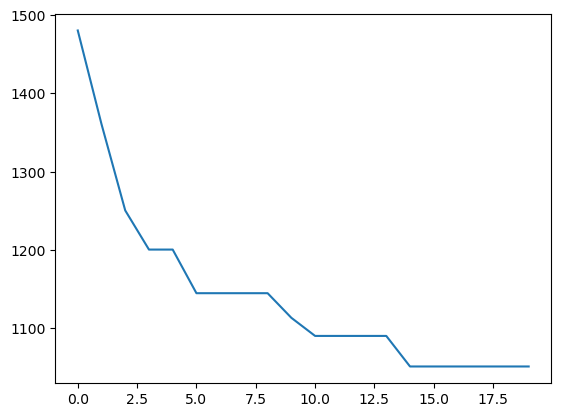

In [454]:
def algo_genetique(population,distances,it):
    iteration = 0
    pop = population.copy()
    #l1 = listes.copy()
    dist_mi = []
    start_time = time.time()
    while(iteration <it ):
        iteration = iteration +1
        pop2 = selection(pop,distances)
        pop3 = croisement(pop2)
        pop3 = [mutation(pop3[i],distances) for i in range(len(pop3))]
        pop = pop + pop3
        d = dist_trajet(pop,distances)
        k = d.index(np.min(d))
        
        dist_mi.append(d[k])
        print(d[k])
        end_time = time.time()
    d = list(dist_trajet(pop,distances)); k = d.index(np.min(d)) # recherche de la distance minimale et ça position
    print("*******************************************************************************")
    print("Un chemin optimale trouvé par l'algorithme à base de fourmis est:",pop[k])
    print("Un trajet optimale est long de",d[k],"Km")
    print("Nombre d'itération:  ",it,)
    print("Temps d'excétution: ",end_time - start_time,"secondes")
    print("*******************************************************************************")
    plt.plot(dist_mi)  
    
algo_genetique(P,M,7)

In [455]:
m =list(dist_trajet(P,M))
k1 = m.index(np.min(m))
che2 = P[k1]
print("Plus court chemin avant l'algorithme")
print(P[k1])
print("Sa distance minimale: ",m[k1])
# 1258.2785925376659   555.9971161590468

Plus court chemin avant l'algorithme
[65, 107, 40, 21, 49, 16, 95, 93, 71, 102, 14, 32, 4, 63, 37, 88, 92, 9, 90, 105, 80, 15, 61, 25, 81, 83, 60, 68, 94, 112, 101, 86, 36, 35, 64, 13, 76, 19, 103, 111, 110, 87, 47, 108, 26, 29, 34, 41, 72, 56, 20, 78, 33, 50, 62, 1, 12, 89, 59, 11, 52, 109, 48, 42, 54, 119, 106, 85, 0, 66, 5, 100, 79, 53, 23, 70, 98, 73, 84, 22, 28, 2, 57, 31, 75, 69, 58, 27, 104, 91, 67, 113, 96, 97, 38, 55, 115, 74, 10, 24, 8, 7, 39, 18, 116, 118, 82, 99, 77, 51, 114, 44, 3, 46, 117, 17, 43, 30, 45, 6]
Sa distance minimale:  2000.1008124024597
